# Music genre classification

## Dataset description

This dataset wad download from kaggle.com. According to the description, it was created as a part of MachineHack Hackathon. [Link to data](https://www.kaggle.com/datasets/purumalgi/music-genre-classification?select=test.csv)

### Features

The dataset has 17 features altogether.

Following table contains dataset feature names, their types and short description:

| Feature name | Type | Description |
| ---- | ---- | ---- |
| Artist Name | string | Artist name |
| Track Name | string | Name of the track |
| Popularity | integer | Measures how the song is popular |
| danceability | float | Measures how the song is danceable  |
| energy | float | Measure how energetic the song is |
| key | categorical | Determines the key of the song |
| loudness | float | Measures how loud the song is |
| mode | categorical | Determines the song's mode |
| speechiness | float | Measures how lyrical the song is |
| acousticness | float | Measure how acoustic the song is |
| instrumentalness | float | Measure how instrumental the song is |
| liveness | float | Measures how lively the song is |
| valence | float | Measures how positive the song is|
| tempo | float | Measures song tempo |
| duration_in min/ms | float | Song duration |
| time_signature | categorical | Determines time signature |
| Class | categorical | Determines which genre the song belongs to |


### Target

The aim of this dataset (and of this notebook) is to train a model to predict the genre a song belongs to. Following table provides overview of genres present in the dataset:

| Class in dataset | Genre |
| ---- | ---- |
| 0 | Acoustic |
| 1 | Alt |
| 2 | Blues |
| 3 | Bollywood |
| 4 | Country |
| 5 | HipHop |
| 6 | Indie |
| 7 | Instrumental |
| 8 | Metal |
| 9 | Pop |
| 10 | Rock |


In [24]:
# import libraries and functions for the whole notebook
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# set seed for reproducible results - sklearn follows this seed as well
np.random.seed(565)

In [272]:
class_translation = {
"0" : "Acoustic",
"1" : "Alt",
"2" : "Blues",
"3" : "Bollywood",
"4" : "Country",
"5" : "HipHop",
"6" : "Indie",
"7" : "Instrumental",
"8" : "Metal",
"9" : "Pop",
"10" : "Rock",
}


## Creating training and testing dataset.

The data provided on kaggle does not have the target variable present in the testing dataset, so the training dataset will be used for the purposes of training and testing. The dataset will be read and split into training and testing. The split will be done in a stratified fashion to preserve the genre distribution between test and train data.

The exploratory analysis and preprocessing will be done only with the training part in order to avoid data leakage from the testing part.

In [273]:
data = pd.read_csv("data/train.csv", dtype={"key": "category", "mode": "category", "time_signature": "category", "Class": "category"})
data["Class_named"] = data["Class"].replace(class_translation)


train, test = train_test_split(data, test_size=0.3, stratify=data["Class"])

# show automatically detected dtypes (will be fixed later)
data.dtypes

Artist Name             object
Track Name              object
Popularity             float64
danceability           float64
energy                 float64
key                   category
loudness               float64
mode                  category
speechiness            float64
acousticness           float64
instrumentalness       float64
liveness               float64
valence                float64
tempo                  float64
duration_in min/ms     float64
time_signature        category
Class                 category
Class_named           category
dtype: object

## Exploratory data analysis

In this section, we will look at how values are distributed in the dataset and how they're individually correlated to the output.

### Missing values

However, first a quick look on missing values in the dataset. It will give overview if certain features can or should be discarded. 

#### Missing values in columns

As it can be seen, only three features have at least one missing value. Result shows percentage of rows in each column that has a missing value. Feature `instrumentalness` is missing a quarter of its values and `key` has 11% missing. Those two features will be discarded due to high amount of missing values. `Popularity` has only 2% values missing, this value is acceptable.

In [274]:
train.isna().sum(axis=0)/train.shape[0] * 100

Artist Name            0.000000
Track Name             0.000000
Popularity             2.413273
danceability           0.000000
energy                 0.000000
key                   11.209018
loudness               0.000000
mode                   0.000000
speechiness            0.000000
acousticness           0.000000
instrumentalness      24.339128
liveness               0.000000
valence                0.000000
tempo                  0.000000
duration_in min/ms     0.000000
time_signature         0.000000
Class                  0.000000
Class_named            0.000000
dtype: float64

#### Missing values in rows

34% of songs have at least 1 feature missing. With the two features being dropped however, the percentage would drop to 2.2%.

In [275]:
(train.isna().sum(axis=1)>0).sum()/train.shape[0]*100

34.325633087243

### Artist name

Artist names are provided as strings. Processing these could be difficult as there are 7286 unique artists in the dataset. There are also some artists represented in multiple unique strings because they can be part of a collaboration between multiple artists. 

Top 10 artists cover 2.56% of all songs. It could be worth to try to include one-hot encoded top N artists as an experiment. Including high number of artists will lead to high cardinality, and the model will probably not be able to capture the relationship for those artists that have just a few songs represented in this dataset. 

In [276]:
print(f"Amount of unique artist strings: {len(train['Artist Name'].unique())}")

top_artists = 10

print(f"Top {top_artists} artists cover {train['Artist Name'].value_counts()[:top_artists].sum()/train.shape[0] * 100:.2f}% of all training data.")

Amount of unique artist strings: 7226
Top 10 artists cover 2.51% of all training data.


### Track name

As can be seen in the output below, there are some track names being represented multiple times. However, these numbers are very low to be significant enough to be used as a variable.

In [277]:
train['Track Name'].value_counts()

Track Name
Hurricane                                                          7
Fire                                                               6
Dreams                                                             6
Ride                                                               5
Over You                                                           5
                                                                  ..
World On Silent                                                    1
Wind Parade                                                        1
Are the Good Times Really Over (I Wish a Buck Was Still Silver)    1
Love Can Pass You By                                               1
◊í◊ú◊í◊ú ◊¢◊†◊ß                                                    1
Name: count, Length: 11065, dtype: int64

### Popularity

Popularity can have integer value in the range of 1-100. The distribution seems to be slightly positively skewed, so filling missing values with median seems like the best choice for missing value imputation. 

The group means differ across different genres. Visually, Country has the highest median, while Bollywood the lowest. Instrumental has the smallest interquartile range and Pop looks to have the highest.

Value range: 1.0 - 100.0


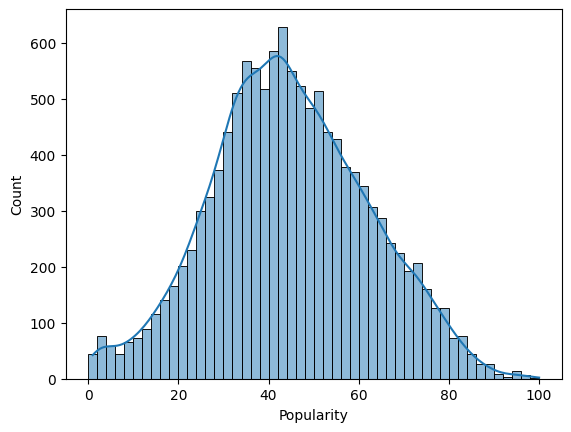

In [278]:
column_name = "Popularity"

print(f"Value range: {min(train[column_name])} - {max(train[column_name])}")

plot = sns.histplot(train[column_name], kde=True, bins=50, binrange=(0,100))
plt.show()

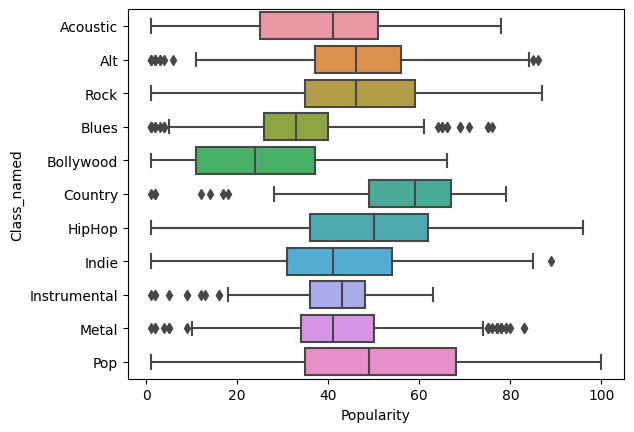

In [279]:
plot = sns.boxplot(data=train, x=column_name, y="Class_named")
plt.show()

### Danceability

Danceability can have real values in the range of 0-1.

The group means differ across different genres. Visually, HipHop has the highest median, while Instrumental and Metal the lowest. 

Value range: 0.0596 - 0.989


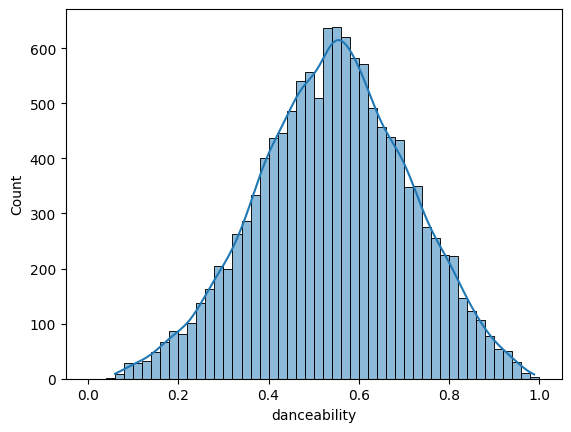

In [280]:
column_name = "danceability"

print(f"Value range: {min(train[column_name])} - {max(train[column_name])}")

plot = sns.histplot(train[column_name], kde=True, bins=50, binrange=(0,1))
plt.show()

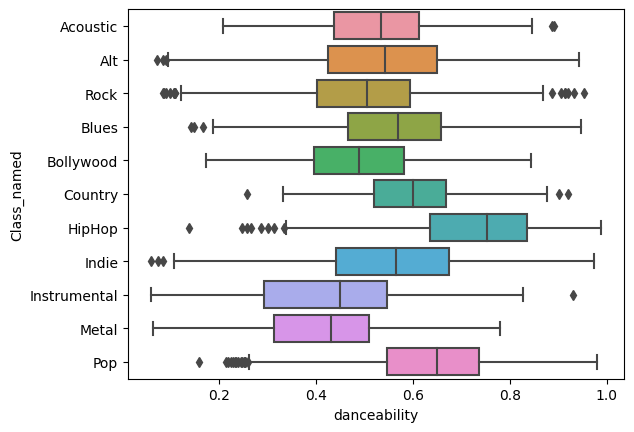

In [281]:
plot = sns.boxplot(data=train, x=column_name, y="Class_named")
plt.show()

### Energy

Energy can have real values in the range of 0-1. The distribution looks highly negatively skewed.

The group means differ across different genres. Visually, Metal has the highest median, while Instrumental has the lowest. These two genres are significantly different from the others.

Value range: 2.03e-05 - 1.0


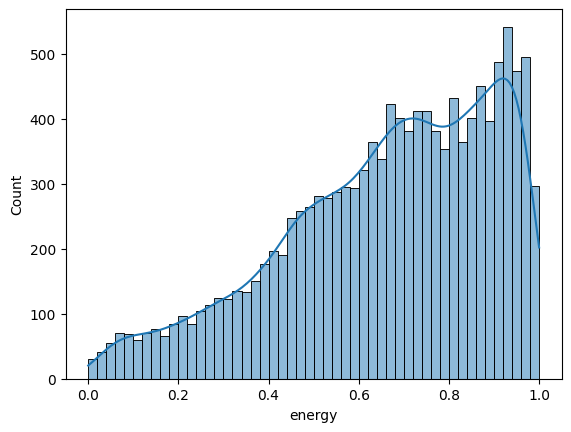

In [282]:
column_name = "energy"

print(f"Value range: {min(train[column_name])} - {max(train[column_name])}")

plot = sns.histplot(train[column_name], kde=True, bins=50, binrange=(0,1))
plt.show()

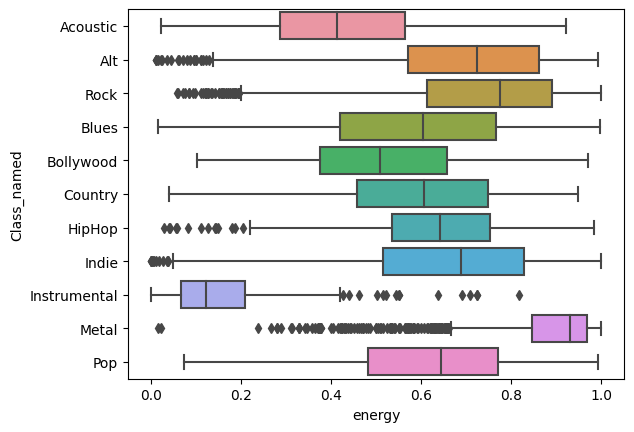

In [283]:
plot = sns.boxplot(data=train, x=column_name, y="Class_named")
plt.show()

### Key

Key is a categorical variable with values 1-11. Key represented as 3 is the least represented and 7 is the highest. 7 is about 4 times as frequent as 3.

From the heatmap, it can be seen that generally Acoustic and instrumental are represented the least. Key `3.0` is the least represeted out of the keys.

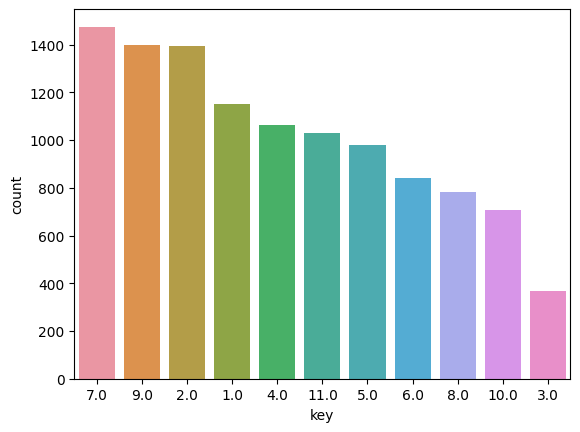

In [284]:
column_name = "key"

plot = sns.countplot(x=train[column_name].dropna(), order=train[column_name].value_counts().index)
plt.show()

<Axes: xlabel='Class_named', ylabel='key'>

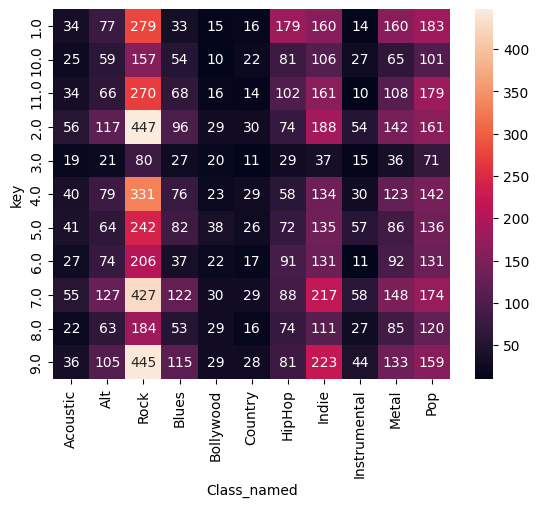

In [285]:
sns.heatmap(pd.crosstab(train[column_name], train["Class_named"]), annot=True, fmt="d")

### Loudness

Loudness can have real values in the range of -34.797 - 1.355. The distribution looks highly negatively skewed.

The group means do differ very significantly across different genres. Visually, only Instrumental stands out significantly.

Value range: -39.952 - 1.355


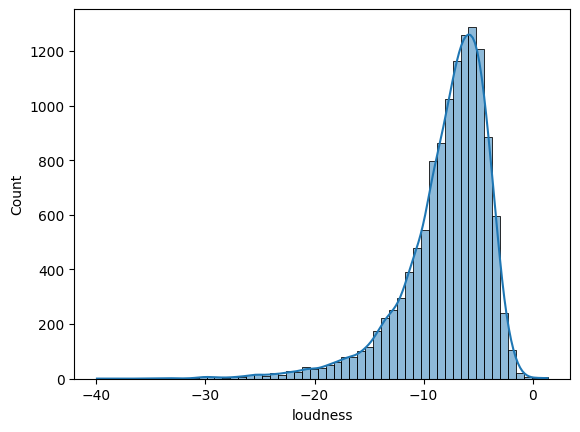

In [286]:
column_name = "loudness"

print(f"Value range: {min(train[column_name])} - {max(train[column_name])}")

plot = sns.histplot(train[column_name], kde=True, bins=50, binrange=(-35,1.4))
plt.show()

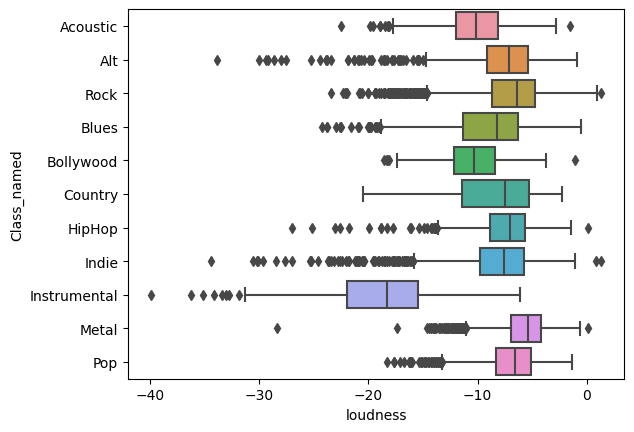

In [287]:
plot = sns.boxplot(data=train, x=column_name, y="Class_named")
plt.show()

### Mode

Key is a categorical variable with values 0-1. Mode represented as 0 is the least represented and 1 is the highest. 1 is about twice as frequent as 0.

From the heatmap, none of the genres seem to be very significantly belong to a specific mode.

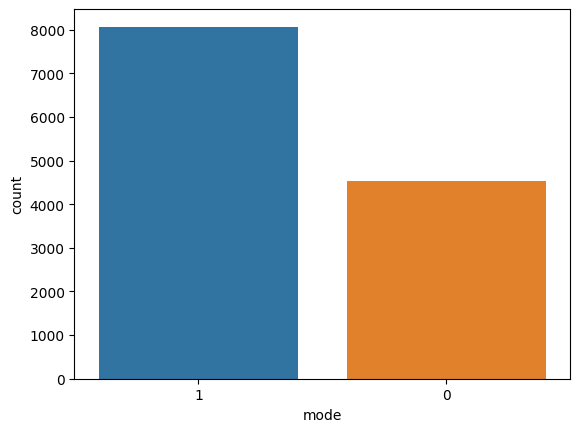

In [288]:
column_name = "mode"

plot = sns.countplot(x=train[column_name].dropna(), order=train[column_name].value_counts().index)
plt.show()

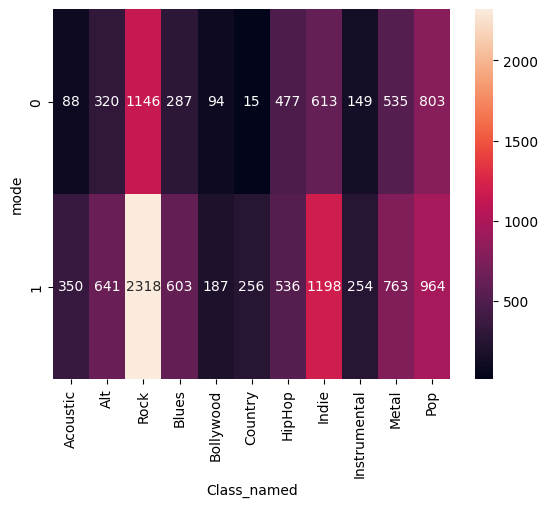

In [289]:
plot = sns.heatmap(pd.crosstab(train[column_name], train["Class_named"]), annot=True, fmt="d")
plt.show()

### Speechiness

Energy can have real values in the range of 0-1. The distribution looks highly positively skewed.

The group means do not differ across different genres with the exception of HipHop. Unsuprisingly, this genre stands out from all the other ones.

Value range: 0.0225 - 0.955


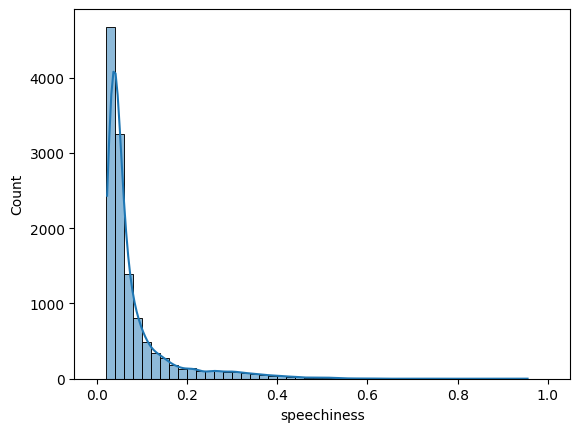

In [290]:
column_name = "speechiness"

print(f"Value range: {min(train[column_name])} - {max(train[column_name])}")

plot = sns.histplot(train[column_name], kde=True, bins=50, binrange=(0,1))
plt.show()

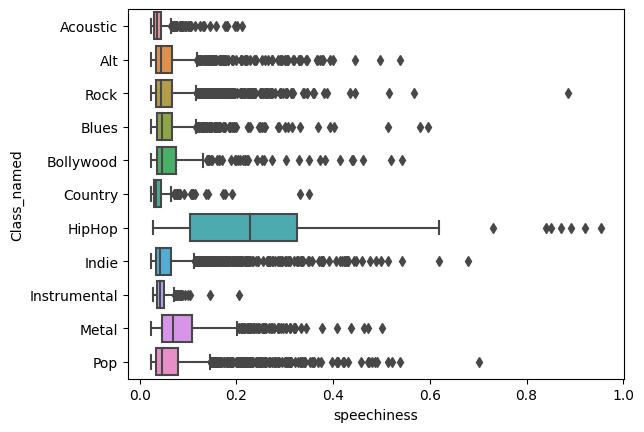

In [291]:
plot = sns.boxplot(data=train, x=column_name, y="Class_named")
plt.show()

### Instrumentalness

Instrumentalness can have real values in the range of 0-1. The distribution uniform across the spectrum with the exception of around 0.

The group means do not differ a lot across different genres. Metal and idiea have slightly higher medians than the rest and Instrumental is the only one that stands out.

Value range: 1e-06 - 0.996


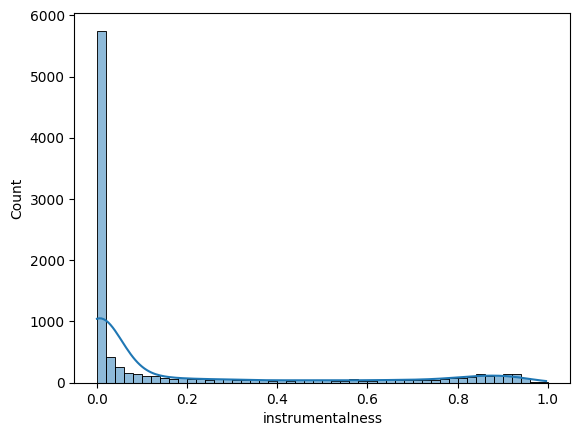

In [292]:
column_name = "instrumentalness"

print(f"Value range: {min(train[column_name])} - {max(train[column_name])}")

plot = sns.histplot(train[column_name], kde=True, bins=50, binrange=(0,1))
plt.show()

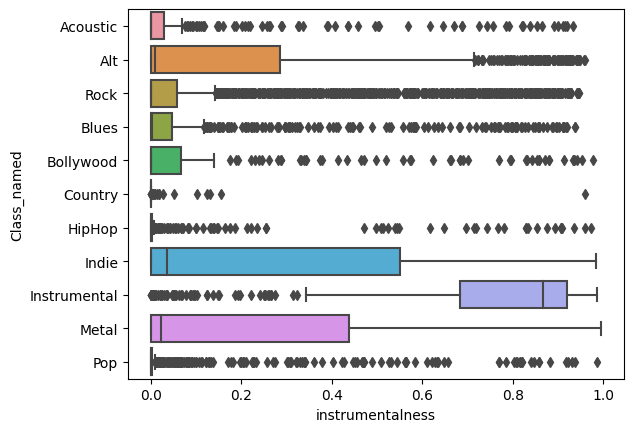

In [293]:
plot = sns.boxplot(data=train, x=column_name, y="Class_named")
plt.show()

### Liveness

Energy can have real values in the range of 0-1. The distribution looks highly positively skewed.

The group means do not differ very significantly across different genres. Visually, Metal is slightly higher than the rest.

Value range: 0.0119 - 0.992


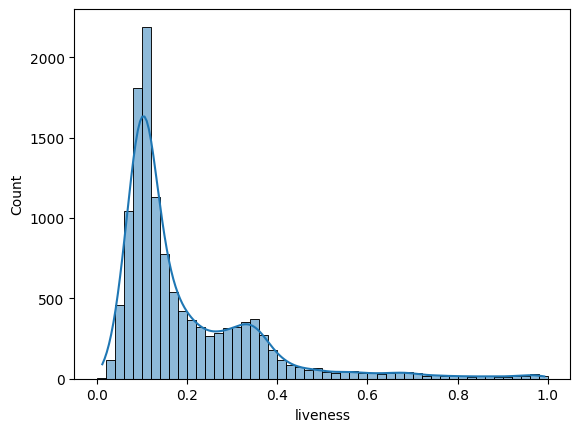

In [294]:
column_name = "liveness"

print(f"Value range: {min(train[column_name])} - {max(train[column_name])}")

plot = sns.histplot(train[column_name], kde=True, bins=50, binrange=(0,1))
plt.show()

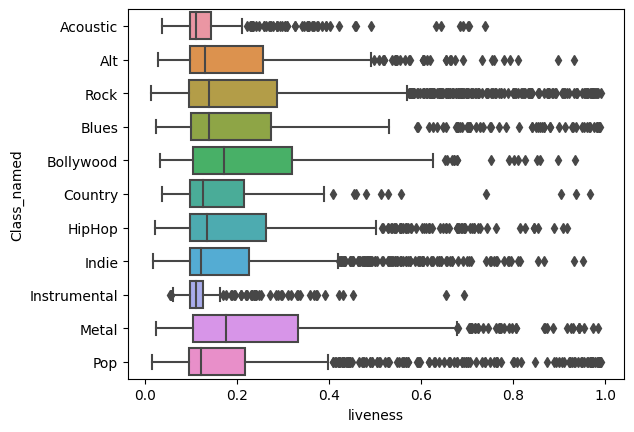

In [295]:
plot = sns.boxplot(data=train, x=column_name, y="Class_named")
plt.show()

### Valence

Valence can have real values in the range of 0-1. The distribution does not look skewed, but it doesn't seem to be normal either.

The group differ across different genres. Visually, Instrumental and Metal are slightly lower than the rest.

Value range: 0.0183 - 0.986


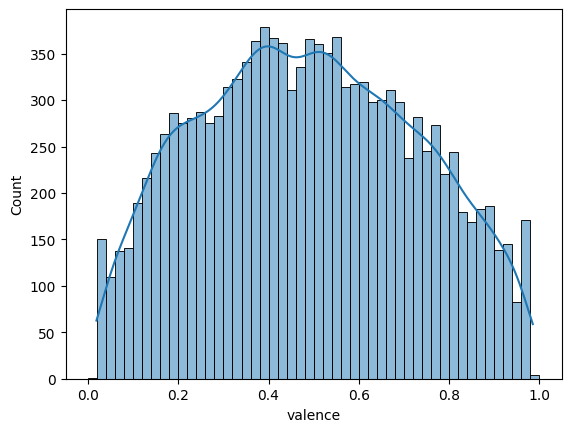

In [296]:
column_name = "valence"

print(f"Value range: {min(train[column_name])} - {max(train[column_name])}")

plot = sns.histplot(train[column_name], kde=True, bins=50, binrange=(0,1))
plt.show()

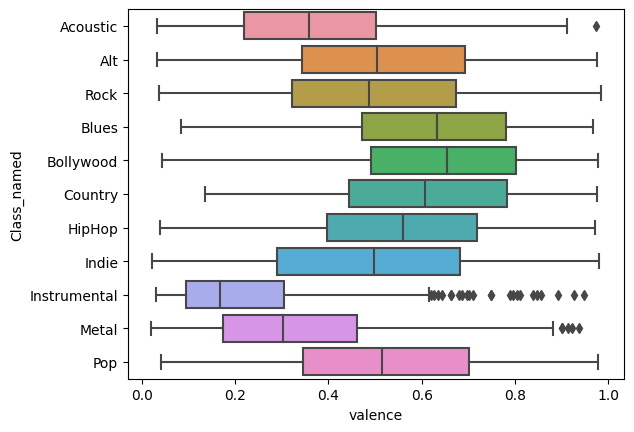

In [297]:
plot = sns.boxplot(data=train, x=column_name, y="Class_named")
plt.show()

### Tempo

Tempo can have real values in the range of 30.557 - 217.416. The distribution looks slightly positively skewed.

The group means do not differ very much across different genres.

Value range: 30.557 - 217.416


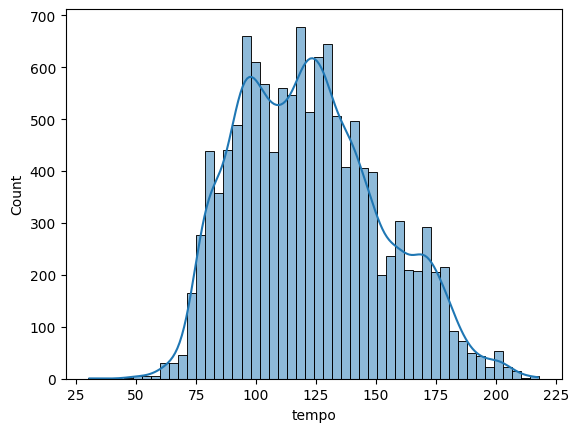

In [298]:
column_name = "tempo"

print(f"Value range: {min(train[column_name])} - {max(train[column_name])}")

plot = sns.histplot(train[column_name], kde=True, bins=50, binrange=(30,218))
plt.show()

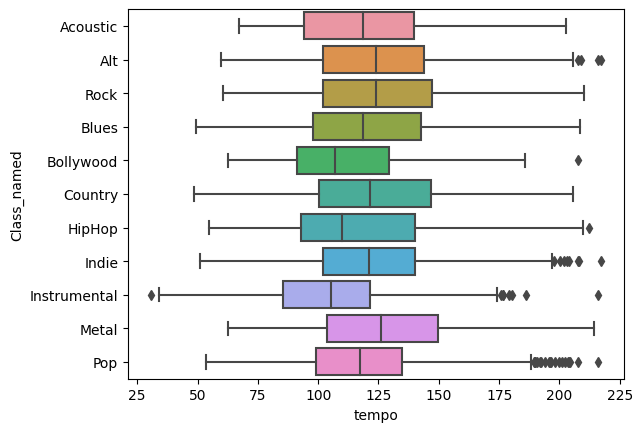

In [299]:
plot = sns.boxplot(data=train, x=column_name, y="Class_named")
plt.show()

### Duration

The duration data seem to be mixing minutes and milliseconds. For illustration, let's take a look at the songs in pictures and their real duration in minutes. In the code cells below, it can be seen one is in milliseconds and one is minutes. 

![title](img/song_minutes.png)

![title](img/song_ms.png)


We will assume that that all songs are at least 8 seconds long. So for converting, we will assume all values under 8000 are in minutes (if the real value would be in milliseconds, the song would be only 8 second log, which is unlikely) and all values above 8000 are in milliseconds (if the real value would be in seconds, the song would be over two hours long, which is also unlikely). We will convert the millisecond values to minutes to bring all songs to the same unit.


In [300]:
# track that is probably in ms
more60000 = train.loc[train["duration_in min/ms"] > 60000, ["Artist Name", "Track Name", "duration_in min/ms"]].iloc[2]
print(f'Track "{more60000["Track Name"]}" by "{more60000["Artist Name"]}" has duration: {more60000["duration_in min/ms"]}')

Track "ZENIT" by "ONUKA" has duration: 271189.0


In [301]:
# track that is probably in minutes
less10 = train.loc[train["duration_in min/ms"] < 10, ["Artist Name", "Track Name", "duration_in min/ms"]].iloc[0]
print(f'Track "{less10["Track Name"]}" by "{less10["Artist Name"]}" has duration: {less10["duration_in min/ms"]}')

Track "Dance: II. Second Movement" by "Oliver Davis, Kerenza Peacock, Huw Watkins, Paul Bateman" has duration: 3.146216667


In [302]:
# convert values to the same unit
train.loc[train["duration_in min/ms"] > 8000, "duration_min"] = train["duration_in min/ms"] / (1000 * 60)
train.loc[train["duration_in min/ms"] <= 8000, "duration_min"] = train["duration_in min/ms"]

test.loc[test["duration_in min/ms"] > 8000, "duration_min"] = test["duration_in min/ms"] / (1000 * 60)
test.loc[test["duration_in min/ms"] <= 8000, "duration_min"] = test["duration_in min/ms"]

After the fix, the durations look a lot more reasonable. 

Duration in train dataset have real values in the range of 0-30. The distribution looks highly positively skewed.

The group means differ slightly across different genres. Bollywood seems to have the highest median and significant outliers.

Value range: 0.38866666666666666 - 29.886


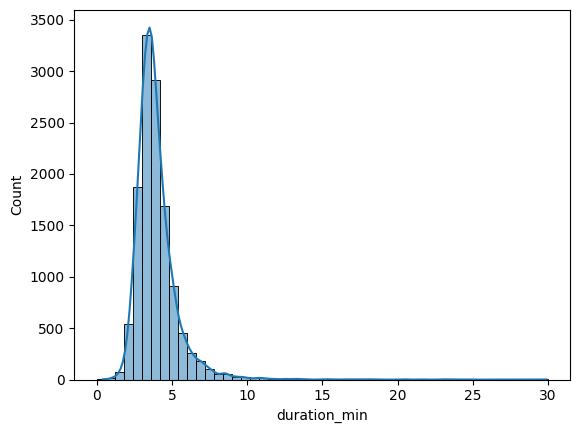

In [303]:
column_name = "duration_min"

print(f"Value range: {min(train[column_name])} - {max(train[column_name])}")

plot = sns.histplot(train[column_name], kde=True, bins=50, binrange=(0,30))
plt.show()

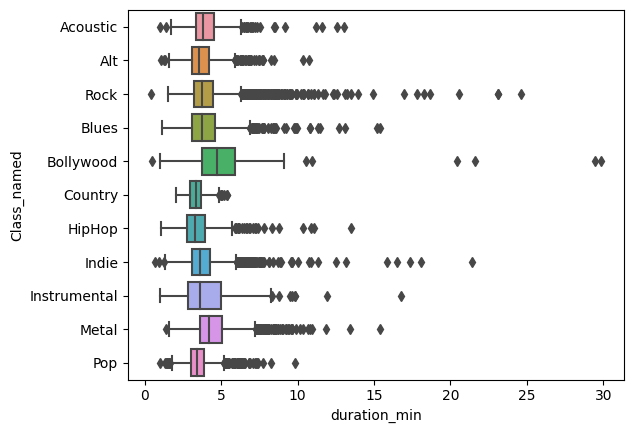

In [304]:
plot = sns.boxplot(data=train, x=column_name, y="Class_named")
plt.show()

### Time signature

Time signature is a categorical variable with 4 categories. The distribution of this variable is very unbalanced.

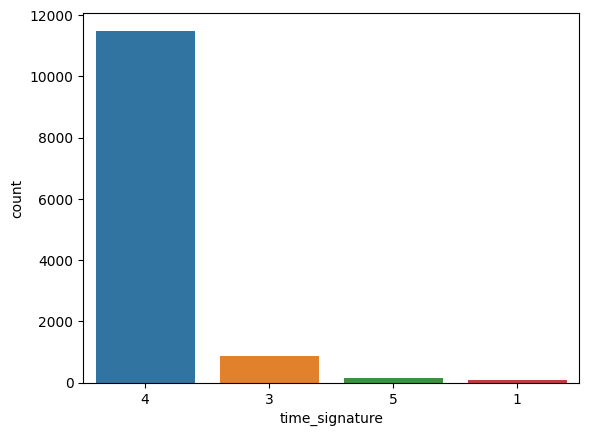

In [305]:
column_name = "time_signature"

plot = sns.countplot(x=train[column_name].dropna(), order=train[column_name].value_counts().index)
plt.show()

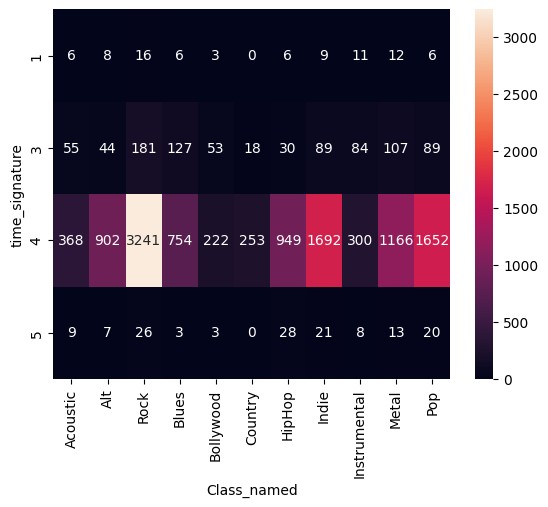

In [306]:
plot = sns.heatmap(pd.crosstab(train[column_name], train["Class_named"]), annot=True, fmt="d")
plt.show()

### Class

Classes are not particularly balanced. If balancing method was to be chosen, bigger classes could be undersamples, smaller ones oversampled, or some technique to impute new observations could be used.

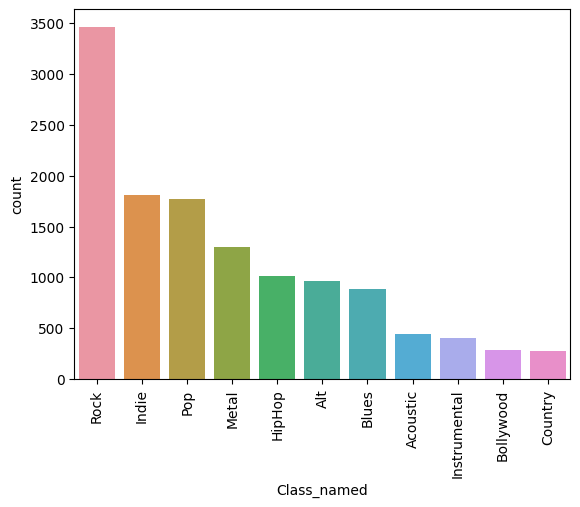

In [307]:
column_name = "Class_named"
plot = sns.countplot(x=train[column_name].dropna(), order=train[column_name].value_counts().index)

plt.setp(plot.get_xticklabels(), rotation=90)
plt.show()

## Preprocessing

### Previously done processing

In the EDA section, we already processed the duration columns. This needed to be done to observe the relationships.

### Dropping columns

As mentioned above, columns `Artist Name` and `Track Name` will be dropped. `duration_in min/ms` will also be dropped as the column for duration will be `duration_min`. The column `Class` will also be dropped since the column with string representing given genre was created.

In [308]:
train = train.drop(columns = ["Artist Name", "Track Name", "duration_in min/ms", "Class"])
test = test.drop(columns = ["Artist Name", "Track Name", "duration_in min/ms", "Class"])

### Treating missing values

#### Dropping columns
As mentioned above, columns with high amount of missing values will be dropped (`instrumentalness`, `key`) and the third remaining column (`Popularity`) will have their missing values filled with the column median.

In [309]:
# drop columns from from train and test
train = train.drop(columns = ["instrumentalness", "key"])
test = test.drop(columns = ["instrumentalness", "key"])

#### Imputing missing values

The imputer is fitted on training data and then used on both training and testing data separately. As can be seen in the output, the quartile values have no changed as expected.

In [119]:
popularity_before = train['Popularity'].describe()
popularity_before.name = "train Popularity before"
popularity_before_test = test['Popularity'].describe()
popularity_before_test.name = "test Popularity before"


popularity_imputer = SimpleImputer(strategy='median', missing_values=np.nan)

# fit on train data
popularity_imputer = popularity_imputer.fit(train[['Popularity']])


#transform train and test popularity column
train['Popularity'] = popularity_imputer.transform(train[['Popularity']])
popularity_after = train['Popularity'].describe()
popularity_after.name = "train Popularity after"

test['Popularity'] = popularity_imputer.transform(test[['Popularity']])
popularity_after_test = test['Popularity'].describe()
popularity_after_test.name = "test Popularity after"


pd.concat([popularity_before, popularity_after, popularity_before_test, popularity_after_test], axis=1)

,train Popularity before,train Popularity after,test Popularity before,test Popularity after
count,12279.000000,12597.000000,5289.000000,5399.000000
mean,44.486685,44.474399,44.571185,44.559548
std,17.371133,17.150625,17.557284,17.377660
min,1.000000,1.000000,1.000000,1.000000
25%,33.000000,33.000000,33.000000,33.000000
50%,44.000000,44.000000,44.000000,44.000000
75%,56.000000,56.000000,56.000000,56.000000
max,100.000000,100.000000,97.000000,97.000000


### Popularity

In [ ]:
###Modelling

In [145]:
#Confusion matrix
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split

# Build a synthetic dataset
X, y = make_classification(
    n_samples=17997, n_features=11, n_informative=9, n_redundant=2, n_classes=11
)

# Fit/predict
etc = ExtraTreesClassifier()
_ = etc.fit(X_train, y_train)
y_pred = etc.predict(X_test)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=())
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=['Popularity', 'danceability', 'energy', 'loudness','speechiness','acousticness','liveness','valence','tempo'],
)

cmp.plot(ax=ax)
plt.show();

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [147]:
# logistic regression for multi-class classification using built-in one-vs-rest
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
# define dataset
X, y = make_classification(n_samples=17997, n_features=14, n_informative=12, n_redundant=2, n_classes=11, random_state=1)
# define model
model = LogisticRegression(multi_class='ovr')
# fit model
model.fit(X, y)
# make predictions
yhat = model.predict(X)

In [7]:
###Remove this section

#Removing the variables for 'key' and 'instrumentalness' due to the high percentage of missing values

data_without_missing_values = train.drop(['key', 'instrumentalness'], axis=1)
data_without_missing_values.head()

,Artist Name,Track Name,Popularity,danceability,energy,loudness,mode,speechiness,acousticness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
6368,Skip James,Cypress Grove Blues,26.0,0.599,0.121,-18.501,1,0.0583,0.9920,0.0933,0.568,102.598,189187.0,4,2
16126,Leah Kate,Boyfriend,52.0,0.898,0.509,-6.038,0,0.1240,0.1580,0.0939,0.555,108.002,143556.0,4,9
8992,ONUKA,ZENIT,46.0,0.658,0.679,-5.766,1,0.0445,0.1070,0.3890,0.247,140.055,271189.0,4,6
4415,Electroforez,–ê–ª–∫–æ–≥–æ–ª—å –º–æ–π –≤—Ä–∞–≥,46.0,0.682,0.877,-4.888,0,0.0410,0.0309,0.0847,0.827,111.964,167000.0,4,6
1457,Grimes,Violence - REZZ Remix,59.0,0.596,0.661,-7.533,0,0.0382,0.0713,0.2090,0.124,99.951,195300.0,4,10


In [8]:
#Removing 'Artist Name' and 'Track Name' due to their unique values and non-essential variables in determing the music genre

data_without_missing_and_redundant_values = data_without_missing_values.drop(['Artist Name', 'Track Name'], axis=1)
data_without_missing_and_redundant_values.head()

,Popularity,danceability,energy,loudness,mode,speechiness,acousticness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
6368,26.0,0.599,0.121,-18.501,1,0.0583,0.9920,0.0933,0.568,102.598,189187.0,4,2
16126,52.0,0.898,0.509,-6.038,0,0.1240,0.1580,0.0939,0.555,108.002,143556.0,4,9
8992,46.0,0.658,0.679,-5.766,1,0.0445,0.1070,0.3890,0.247,140.055,271189.0,4,6
4415,46.0,0.682,0.877,-4.888,0,0.0410,0.0309,0.0847,0.827,111.964,167000.0,4,6
1457,59.0,0.596,0.661,-7.533,0,0.0382,0.0713,0.2090,0.124,99.951,195300.0,4,10


In [9]:
(data_without_missing_and_redundant_values.isna().sum(axis=1)>0).sum()/data_without_missing_and_redundant_values.shape[0]*100

2.413273001508296

In [21]:
#Missing values in popularity variable are replaced using median() as animputation technique. 
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median', missing_values=np.nan)
imputer = imputer.fit(data_without_missing_and_redundant_values[['Popularity']])
data_without_missing_and_redundant_values['Popularity'] = imputer.transform(data_without_missing_and_redundant_values[['Popularity']])
data_without_missing_and_redundant_values.head()

,Popularity,danceability,energy,loudness,mode,speechiness,acousticness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
6368,26.0,0.599,0.121,-18.501,1,0.0583,0.9920,0.0933,0.568,102.598,189187.0,4,2
16126,52.0,0.898,0.509,-6.038,0,0.1240,0.1580,0.0939,0.555,108.002,143556.0,4,9
8992,46.0,0.658,0.679,-5.766,1,0.0445,0.1070,0.3890,0.247,140.055,271189.0,4,6
4415,46.0,0.682,0.877,-4.888,0,0.0410,0.0309,0.0847,0.827,111.964,167000.0,4,6
1457,59.0,0.596,0.661,-7.533,0,0.0382,0.0713,0.2090,0.124,99.951,195300.0,4,10


In [22]:
(data_without_missing_and_redundant_values.isna().sum(axis=1)>0).sum()/data_without_missing_and_redundant_values.shape[0]*100

0.0

RandomForestClassifier(max_depth=5, random_state=1)

In [72]:
X_test = pd.get_dummies(test[Features]) 
X_test.count()

Popularity      5275
danceability    5399
energy          5399
loudness        5399
speechiness     5399
acousticness    5399
liveness        5399
valence         5399
tempo           5399
dtype: int64

In [62]:
###Model Development and predictons



['2', '9', '6', '6', '10']
Categories (11, object): ['0', '1', '10', '2', ..., '6', '7', '8', '9']

In [66]:
#Model fitting
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [68]:
model.fit(X_train, y_train)

LogisticRegression()

In [70]:
y_predict = model.predict(X_test)
y_predict[:10]

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## Preprocessing

TODO

> Requirements on preprocessing
> 
> Any two of the following operations are mandatory:
> 
> -     remove rows based on subsetting
> -     derive new columns
> -     use aggregation operators
> -     treat missing values


TODO remove instrumentalness


## Modeling

TODO

> Requirements
> 
> Use any classifier. Choose one of the following two options:
> 
> -     perform train/test split
> -     use crossvalidation
> 
> Also, evaluate and compare at least two algorithms of different types (e.g. logistic regression and random forest).
> Any classifier from `sklearn`

### Hyperparameter tuning

TODO

> Requirements on metaparameter tuning
> 
> If the chosen classifier has any metaparameters that can be tuned, use one of the following methods:
> 
>  -   try several configurations and describe the best result in the final report
>  -   perform grid search or other similar automatic method
>  -   once you have tuned metaparameters on a dedicated development (training) set, e.g. with GridSearchCV, you can retrain the model on the complete training data, as e.g. described here for Python: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html and https://stackoverflow.com/questions/26962050/confused-with-repect-to-working-of-gridsearchcv
> 
> Python recommendation: sklearn.model_selection.GridSearchCV

## Results and evaluation

TODO

> Requirements on model evaluation
> 
> -    report the accuracy on test set/crossvalidation
> -    if you are performing binary classification task, involve also the ROC curve
> -    make sure to use dedicated dataset for evaluation
> 
> Python: use model_selection.cross_val_score, plot the roc curve using sklearn.metrics.roc_curve R: print model learned using the caret package, the roc curve can be plotted using the plotROC package.